### Import required libraries

In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense,Dropout,LSTM,BatchNormalization,SimpleRNN,Embedding
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
import pandas as pd
import nltk
import re
from matplotlib import pyplot

### Download NLTK packages

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Defining the output sample space of possible languages

In [3]:
lang=['javascript','sql','python','java','c#','php','c++','c','ruby','swift','r','vba','objective-c','scala','html','shell']
lang_index = dict(zip(lang,(i for i in range(len(lang)))))
reverse_lang_index = dict(map(reversed, lang_index.items()))

### Load and filter the datasets based on above defined output sample space

NOTE :- I am considering HTML/CSS as one single language and Bash/Shell/PowerShell as one single language

In [4]:
sf_tags = pd.read_csv(r'/content/Tags.csv',encoding="ISO-8859-1",)
sf_tags = sf_tags.loc[sf_tags['Tag'].isin(lang)]
sf_tags = sf_tags.drop_duplicates(subset='Id')
sf_qstn = pd.read_csv(r'/content/Questions.csv',encoding="ISO-8859-1")
sf_qstn = sf_qstn.loc[sf_qstn['Id'].isin(sf_tags['Id'])]
sf_tags.Tag.replace(to_replace=dict(css='html',bash='shell',powershell='shell'), inplace=True)
sf_tags.set_index('Id',inplace=True)
sf_qstn.set_index('Id',inplace=True)

In [5]:
sf_qstn.head(10)

,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
Id,,,,,,
120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...
330,63.0,2008-08-02T02:51:36Z,NaN,29,Should I use nested classes in this case?,<p>I am working on a collection of classes use...
650,143.0,2008-08-03T11:12:52Z,NaN,79,Automatically update version number,<p>I would like the version property of my app...
930,245.0,2008-08-04T00:47:25Z,NaN,28,How do I connect to a database and loop over a...,<p>What's the simplest way to connect and quer...
1010,67.0,2008-08-04T03:59:42Z,NaN,14,"How to get the value of built, encoded ViewState?",<p>I need to grab the base64-encoded represent...
1040,254.0,2008-08-04T05:45:22Z,NaN,42,How do I delete a file which is locked by anot...,<p>I'm looking for a way to delete a file whic...
1760,234.0,2008-08-05T00:51:49Z,NaN,51,.NET Unit Testing packages?,<p>Getting back into a bit more .NET after a f...
1970,116.0,2008-08-05T06:39:31Z,NaN,10,What language do you use for PostgreSQL trigge...,<p>PostgreSQL is interesting in that it suppor...


In [6]:
sf_tags.head(10)

,Tag
Id,
120,sql
260,c#
330,c++
650,c#
930,c#
1010,c#
1040,c#
1760,c#
1970,sql


### Merging the questions with their respective tags into a single dataset

In [7]:
col_merged = pd.concat([sf_qstn[['Title','Body']], sf_tags[['Tag']]], axis=1)
col_merged.head(10)

,Title,Body,Tag
Id,,,
120,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql
260,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c#
330,Should I use nested classes in this case?,<p>I am working on a collection of classes use...,c++
650,Automatically update version number,<p>I would like the version property of my app...,c#
930,How do I connect to a database and loop over a...,<p>What's the simplest way to connect and quer...,c#
1010,"How to get the value of built, encoded ViewState?",<p>I need to grab the base64-encoded represent...,c#
1040,How do I delete a file which is locked by anot...,<p>I'm looking for a way to delete a file whic...,c#
1760,.NET Unit Testing packages?,<p>Getting back into a bit more .NET after a f...,c#
1970,What language do you use for PostgreSQL trigge...,<p>PostgreSQL is interesting in that it suppor...,sql


### This step include two steps :-
i) Truncate the combined dataset into 10000 or less datapoints per language

ii) Convert the target values into One-hot Encoding of their respective language

In [8]:
data=[]
for i in lang:
  is_lan = col_merged['Tag'] == i
  store = col_merged[is_lan]
  if(store.shape[0]>10000):
    store = store.iloc[:10000,]
  for j in range(store.shape[0]):
    data.append(store.iloc[j])


data = pd.DataFrame(data)
data = data.sample(frac=1).reset_index(drop=True)
data.columns=['Title','Body','Tag']
tag_count = data['Tag'].value_counts().to_dict()
data['Questions']=data['Title'] + data['Body']
data['Tag'] = data['Tag'].apply(lambda x: lang_index[x])
data['Tag']=data['Tag'].apply(lambda x: to_categorical(x,num_classes=16))

In [9]:
tag_count

{'c': 10000,
 'c#': 10000,
 'c++': 10000,
 'html': 10000,
 'java': 10000,
 'javascript': 10000,
 'objective-c': 10000,
 'php': 10000,
 'python': 10000,
 'r': 10000,
 'ruby': 10000,
 'scala': 5101,
 'shell': 4125,
 'sql': 10000,
 'swift': 10000,
 'vba': 6442}

In [10]:
from nltk import word_tokenize
def remove_html_tags(text):
  """Remove html tags from a string"""
  clean = re.compile('<.*?>')
  return re.sub(clean, '', text)

def expand_contractions(text):
  from contractions import  contractions_dict
  pattern = re.compile("({})".format("|".join( contractions_dict.keys())),flags = re.DOTALL| re.IGNORECASE)
    
  def replace_text(t):
    txt = t.group(0)
    if txt.lower() in  contractions_dict.keys():
      return  contractions_dict[txt.lower()]
        
  expand_text = pattern.sub(replace_text,text)
  return expand_text 

def clean_text(text):
  filters = '!"$%&\'()*,-./:;<=>?@[\\]^_`{|}~0123456789'
  text = "".join([word for word in text if word not in filters])
  stop_wor = nltk.corpus.stopwords.words('english')
  text = [word for word in word_tokenize(text) if word not in stop_wor]
  wn = nltk.WordNetLemmatizer()
  text = [wn.lemmatize(word) for word in text]
  return text

### Pre-processing the dataset
i) Remove the HTML tags from the text corpus

ii) Expanding all cotractions in the text corpus

iii) Clean the text corpus by removing all punctuations, stop words and them doing lemmatization on the corpus

In [11]:
data['Questions']=data['Questions'].apply(lambda x: remove_html_tags(x.lower()))
data['Questions']=data['Questions'].apply(lambda x: expand_contractions(x))
data['Questions']=data['Questions'].apply(lambda x: clean_text(x))

### Preparing the training dataset

Using Tokenizer to convert words to vectors

In [12]:
size= 121134
tokenizer = Tokenizer(num_words = None,oov_token="<OOV>",filters='')
tokenizer.fit_on_texts(data['Questions'][:size])
word_index = tokenizer.word_index
sequences_train = tokenizer.texts_to_sequences(data['Questions'][:size])
sequences_train = np.array(sequences_train)
sequences_train = pad_sequences(sequences_train, maxlen=76, padding="pre", truncating="post")

x_train = sequences_train
y_train = np.array(data['Tag'][:size])
y_train = np.stack( y_train, axis=0 )

### Preparaing the weight matrix of embedding layer

In [13]:
size_of_vocabulary = len(word_index) + 1
embeddings_index = dict()
f = open(r'glove.6B.300d.txt',encoding="utf8")

for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

embedding_matrix = np.zeros((size_of_vocabulary, 300))

for word, i in tokenizer.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

Loaded 400000 word vectors.


### Initializing the model
We are using :-

i) Sequential model with one non trainable embedding layer, three LSTM layers and one dense layers

ii) Dropout to prevent overfitting

In [14]:
model = Sequential()
model.add(Embedding(size_of_vocabulary,300,weights=[embedding_matrix],input_length=76,trainable=False))
model.add(LSTM(64,return_sequences=True,dropout=0.5))
model.add(LSTM(64,return_sequences=True,dropout=0.5))
model.add(LSTM(64,dropout=0.5))
model.add(Dense(16,activation='softmax'))

### Compiling the model
We are using categorical cross entropy loss function and categorical accuracy for metrics evalation with adam optimizer

In [15]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics = [metrics.CategoricalAccuracy()])

### Fitting model

Epoch 1/100
95/95 [==============================] - 17s 174ms/step - loss: 2.1893 - categorical_accuracy: 0.3003 - val_loss: 1.6030 - val_categorical_accuracy: 0.5007
Epoch 2/100
95/95 [==============================] - 15s 157ms/step - loss: 1.5258 - categorical_accuracy: 0.5317 - val_loss: 1.2207 - val_categorical_accuracy: 0.6288
Epoch 3/100
95/95 [==============================] - 15s 160ms/step - loss: 1.2489 - categorical_accuracy: 0.6250 - val_loss: 1.0659 - val_categorical_accuracy: 0.6869
Epoch 4/100
95/95 [==============================] - 15s 160ms/step - loss: 1.1103 - categorical_accuracy: 0.6664 - val_loss: 0.9744 - val_categorical_accuracy: 0.7102
Epoch 5/100
95/95 [==============================] - 15s 158ms/step - loss: 1.0300 - categorical_accuracy: 0.6895 - val_loss: 0.9039 - val_categorical_accuracy: 0.7296
Epoch 6/100
95/95 [==============================] - 15s 161ms/step - loss: 0.9729 - categorical_accuracy: 0.7068 - val_loss: 0.8663 - val_categorical_accuracy:

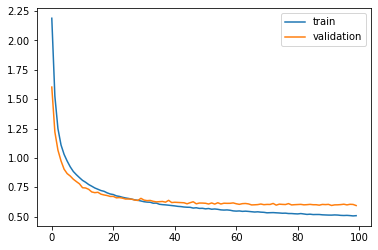

In [16]:
history = model.fit(x_train,y_train,epochs=100,batch_size=1024,validation_split=0.2)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

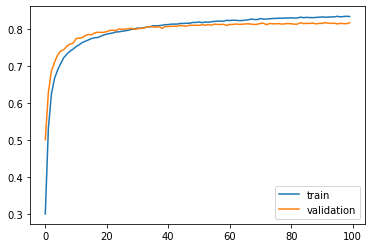

In [17]:
pyplot.plot(history.history['categorical_accuracy'], label='train')
pyplot.plot(history.history['val_categorical_accuracy'], label='validation')
pyplot.legend()
pyplot.show()

### Preparing the test dataset

In [18]:
sequences_test = tokenizer.texts_to_sequences(data['Questions'][size:])
sequences_test = np.array(sequences_test)
sequences_test = pad_sequences(sequences_test, maxlen=76, padding="pre", truncating="post")

x_test = sequences_test
y_test = np.array(data['Tag'][size:])
y_test= np.stack( y_test, axis=0 )

### Evaluating the performance of our trained model on test set

In [19]:
model.evaluate(x_test,y_test)

767/767 [==============================] - 20s 26ms/step - loss: 0.5762 - categorical_accuracy: 0.8235


[0.5762450098991394, 0.8234694600105286]

### Plotting Confusion matrix on predicted test set

In [21]:
rounded_predictions = model.predict_classes(x_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [22]:
cm = confusion_matrix(y_true=np.argmax(y_test,axis=1), y_pred=rounded_predictions)

In [23]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      cm = np.around(cm,2)
      print("Normalized confusion matrix")
    else:
      print('Confusion matrix, without normalization')

    plt.figure(figsize = (13,13))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


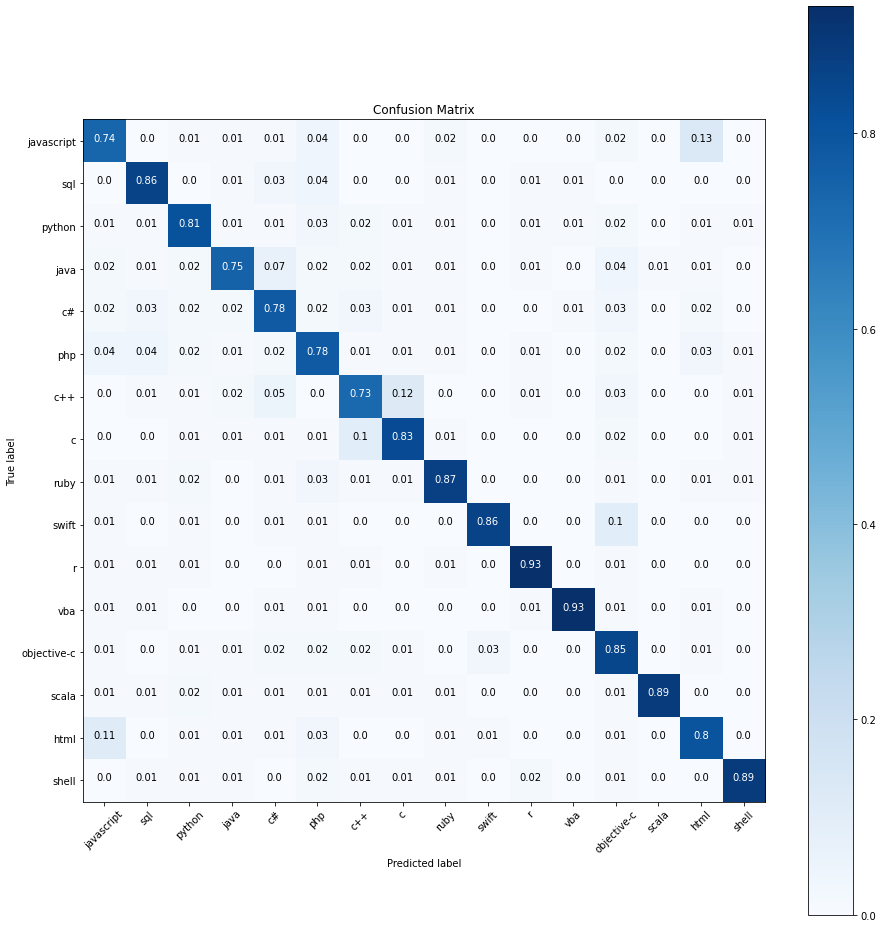

In [24]:
plot_confusion_matrix(cm=cm, classes=lang, title='Confusion Matrix',normalize=True)

### Evaluating performance on random tokens of data

In [25]:
def demo(dem):
  reverse_lang_index = dict(map(reversed, lang_index.items()))
  demo_s = clean_text(dem)
  demo_s = np.array(tokenizer.texts_to_sequences(demo_s))
  demo_s = demo_s.reshape((1,demo_s.shape[0]))
  demo_s = pad_sequences(demo_s, maxlen=76, padding="pre", truncating="post")
  pred = np.around(model.predict(demo_s))
  num = np.argmax(pred)
  langu_age = reverse_lang_index[num]
  return langu_age

In [26]:
demo('How to pause and resume a while loop in Python ? I want to have a loop running that will print "Hello" and when I press "K" it stops printing but it does not end the program, then when I press "K" again it starts printing again.')

'python'